In [1]:
import numpy as np
import xarray as xr
from netCDF4 import Dataset
import gc 
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.cm import get_cmap
import cartopy.crs as crs; import cartopy.feature as cf
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

from wrf import (getvar, interplevel,interpline, to_np, latlon_coords, CoordPair, vertcross, 
                 get_cartopy, cartopy_xlim, cartopy_ylim)
from warnings import filterwarnings
filterwarnings('default') # change to ignore just incase warning appears

#### Directories to the successful compilation logs

 <kbd>/glade/scratch/noteng/lab6/WPS/metgrid.out</kbd>
 <br>
 <kbd>/glade/scratch/noteng/lab6/WPS/geogrid.out</kbd>
 <br>
 <kbd>/glade/scratch/noteng/lab6/WPS/ungrib.out</kbd>
 <br>
 <kbd>/glade/scratch/noteng/lab6/WRF/compile.log</kbd>

In [2]:
%%time
# Path to WRF File
path = '/glade/scratch/noteng/lab6/WRF/test/em_real/cold_start/'
file = 'wrfout_d01_2011-04-28_18:00:00'
wrfnc = Dataset(path+file)

CPU times: user 52.3 ms, sys: 20.1 ms, total: 72.5 ms
Wall time: 103 ms


# QUESTION 1 AND 3

In [3]:
%%time
#creating function to calculate wind speed of both u and v components of the wind
def wind_uv_speed(u,v):
    WSpd = (np.sqrt(np.square(u)+np.square(v)))
    return WSpd

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.96 µs


In [4]:
%%time
def wrf_contour_wind_plot(ncfile, pressure_level, Uwind_levels, cmap='Blues', resolution='50m'):
    
    # Extract the pressure, geopotential height, and wind variables
    p = getvar(ncfile, "pressure")
    z = getvar(ncfile, "z")
    Ua = getvar(ncfile, "ua", units='kts')
    Va = getvar(ncfile, "va", units='kts')
       
    # Interpolate geopotential height, u, and v winds to the pressure level
    hgt = interplevel(z, p, pressure_level)
    Ua_at_p = interplevel(Ua, p, pressure_level) 
    Va_at_p = interplevel(Va, p, pressure_level)

    # Get the lat/lon coordinates
    lats, lons = latlon_coords(hgt)

    # get the WRF local cosine and sines of the map rotation
    cosalpha = ncfile.variables['COSALPHA'][0]
    sinalpha = ncfile.variables['SINALPHA'][0]
    
    # rotate grid-relative winds to earth-relative using the correct formulas
    Ue = Ua_at_p * cosalpha - Va_at_p * sinalpha
    Ve = Va_at_p * cosalpha + Ua_at_p * sinalpha
    wspd = wind_uv_speed(Ue, Ve)
    # Get the map projection information
    cart_proj = get_cartopy(hgt)

    # Create the figure
    fig = plt.figure(figsize=(12,12))
    fig.patch.set_facecolor('xkcd:white') #Set the background = ‘white'
    ax = plt.axes(projection=cart_proj)
    ax.coastlines(resolution, linewidth=2)
    ax.add_feature(cf.BORDERS, linewidth=2)

    # Add the pressure level geopotential height contours
    hgt_contours = ax.contour(to_np(lons), to_np(lats), to_np(hgt),
                           colors="black", transform=crs.PlateCarree())
    ax.clabel(hgt_contours)

    # Add the wind speed contours
    Uwind_contours = ax.contourf(to_np(lons), to_np(lats), to_np(wspd), levels=Uwind_levels,
                                 cmap=get_cmap(cmap), transform=crs.PlateCarree(), extend='both')
    
    # Add the wind barbs, only plotting every 10th data point.
    ax.barbs(to_np(lons[::10,::10]), to_np(lats[::10,::10]), to_np(Ue[::10, ::10]), 
              to_np(Ve[::10, ::10]), transform=crs.PlateCarree(), length=6)
    
    # Set the map bounds and axes title
    ax.set(xlim=(cartopy_xlim(hgt)),ylim=(cartopy_ylim(hgt)) )

    gl = ax.gridlines(x_inline=False); gl.bottom_labels=True; gl.left_labels=True
    gl.xformatter = LONGITUDE_FORMATTER; gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'color': 'red', 'weight': 'bold', 'rotation': 45}; gl.ylabel_style = {'color': 'green', 'weight': 'bold'}

    cax = fig.add_axes([0.11,0.05,0.8,0.03])
    cbar = plt.colorbar(Uwind_contours, cax=cax, orientation="horizontal", ticks=Uwind_levels)
    cbar.set_label('$U_{zonal}$ Velocity (Kts)', fontsize=12)
    ax.set_title(f'{pressure_level} hPa horizontal windspeed[kts] (2011-04-28 at 1800 UTC over the United States)', fontsize = 14, fontweight='bold',  pad=13)
    plt.savefig('./%s.png' %(f'labs4dynamics/lab6/{pressure_level}mb_2011-04-28_Uwind'),bbox_inches='tight', dpi=100)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.96 µs


## For 500 hPa

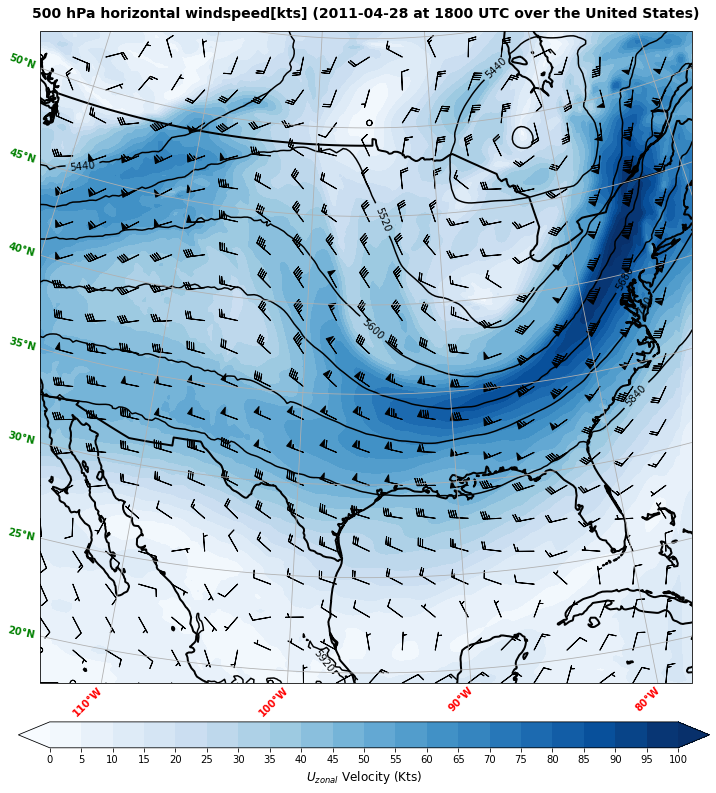

In [5]:
wrf_contour_wind_plot(wrfnc, 500, np.arange(0,105,5))

## For 850 hPa

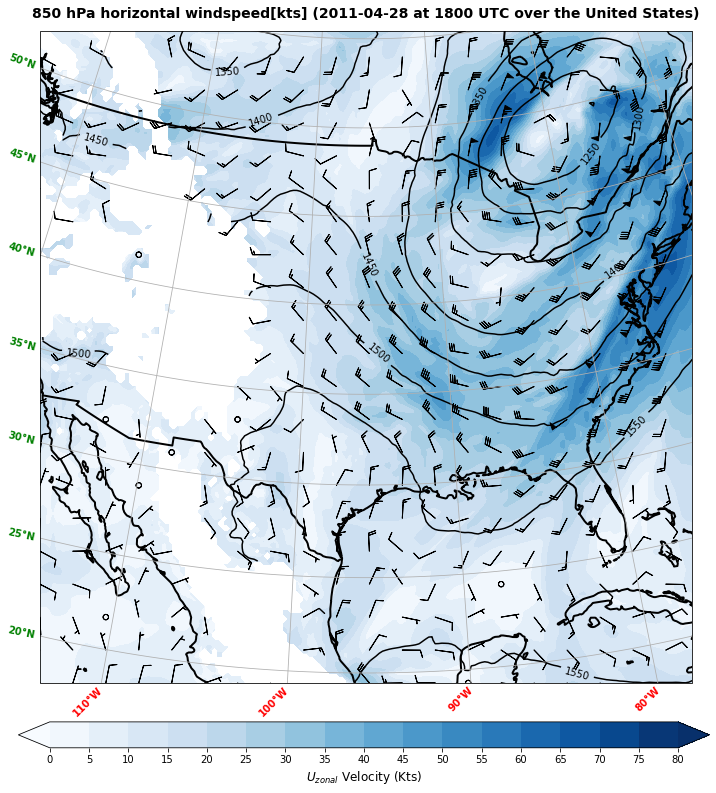

In [6]:
wrf_contour_wind_plot(wrfnc, 850, np.arange(0,85,5))

## For 250 hPa

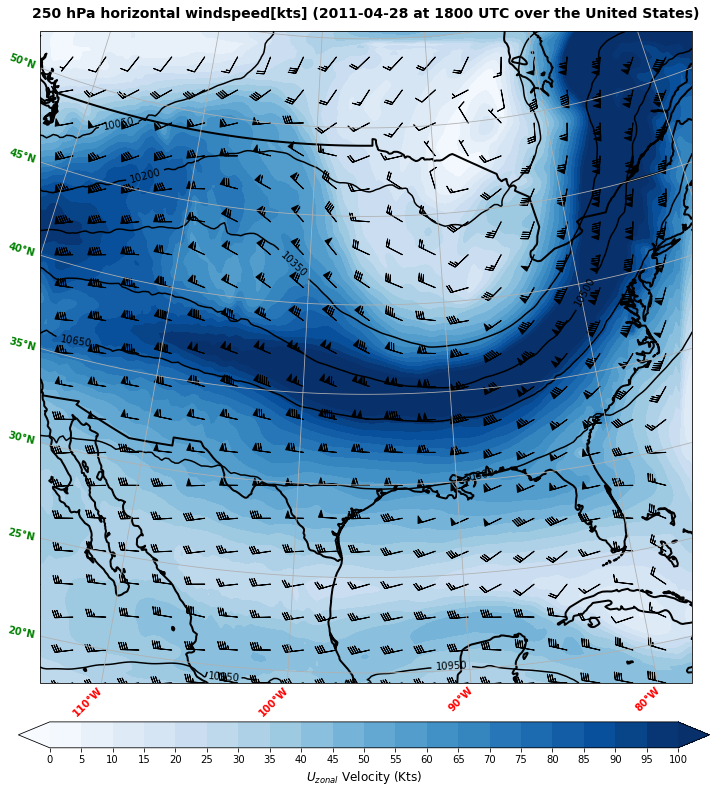

In [7]:
wrf_contour_wind_plot(wrfnc, 250, np.arange(0,105,5))

# Question 2

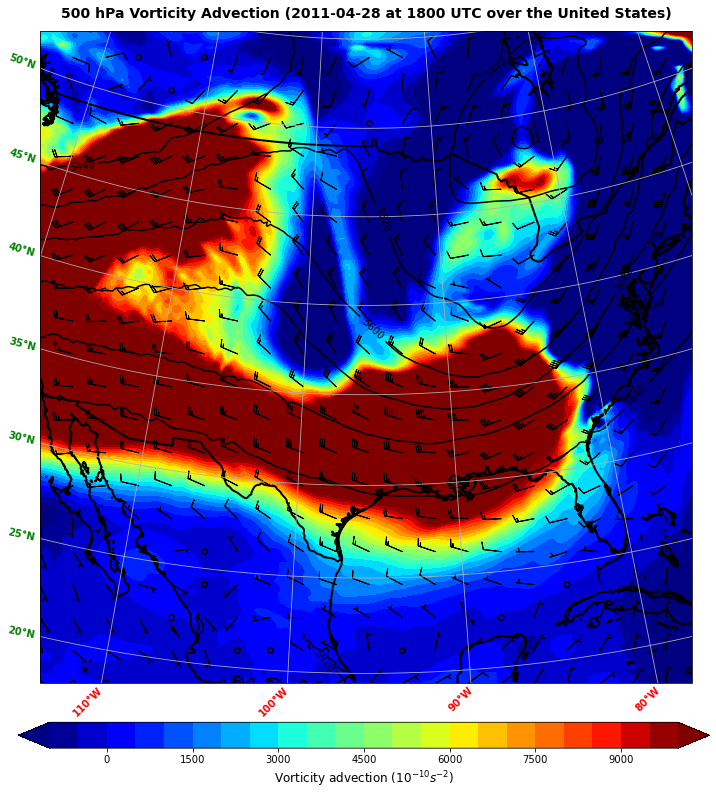

In [8]:
# Extract the pressure, geopotential height, and wind variables
p = getvar(wrfnc, "pressure")
z = getvar(wrfnc, "z")
Ua = getvar(wrfnc, "ua")
Va = getvar(wrfnc, "va")


# Interpolate geopotential height, vorticity advection, u, and v winds to the pressure level
hgt = interplevel(z, p, 500)
Ua_at_p = interplevel(Ua, p, 500) 
Va_at_p = interplevel(Va, p, 500)


# Get the lat/lon coordinates
lats, lons = latlon_coords(hgt)

# get the WRF local cosine and sines of the map rotation
cosalpha = wrfnc.variables['COSALPHA'][0]
sinalpha = wrfnc.variables['SINALPHA'][0]

# rotate grid-relative winds to earth-relative using the correct formulas
Ue = Ua_at_p * cosalpha - Va_at_p * sinalpha
Ve = Va_at_p * cosalpha + Ua_at_p * sinalpha

# Calculate the vertical vorticity:
vert_vort = (Va_at_p.diff('x')/20000) - (Ua_at_p.diff('y')/20000)

# Calculate the vorticity advection:
vort_adv = -(Ua_at_p*vert_vort.diff('x')/20000) - (Va_at_p*vert_vort.diff('y')/20000)
vort_adv = vort_adv*1e+10

# Get the map projection information
cart_proj = get_cartopy(hgt)

# Create the figure
fig = plt.figure(figsize=(12,12))
fig.patch.set_facecolor('xkcd:white') #Set the background = ‘white'
ax = plt.axes(projection=cart_proj)

# Add the coastlines and borders
ax.coastlines('10m', linewidth=2)
ax.add_feature(cf.BORDERS, linewidth=2)

# Add the pressure level geopotential height contours
hgt_contours = ax.contour(to_np(lons), to_np(lats), to_np(hgt),
                       colors="black", transform=crs.PlateCarree())
ax.clabel(hgt_contours)

# Add the Vorticity advection contours
vort_levels = np.arange(-1000,10500,500)
vort_advection_contours = ax.contourf(to_np(lons), to_np(lats), to_np(vort_adv), levels= vort_levels,
                             cmap=get_cmap('jet'), transform=crs.PlateCarree(), extend='both')

# Add the wind barbs, only plotting every 10th data point.
ax.barbs(to_np(lons[::10,::10]), to_np(lats[::10,::10]), to_np(Ue[::10, ::10]), 
          to_np(Ve[::10, ::10]), transform=crs.PlateCarree(), length=6)

# Set the map bounds and axes title
gl = ax.gridlines(x_inline=False); gl.bottom_labels=True; gl.left_labels=True
gl.xformatter = LONGITUDE_FORMATTER; gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'color': 'red', 'weight': 'bold', 'rotation': 45}; gl.ylabel_style = {'color': 'green', 'weight': 'bold'}

cax = fig.add_axes([0.11,0.05,0.8,0.03])
cbar = plt.colorbar(vort_advection_contours, cax=cax, orientation="horizontal")#, ticks=vort_levels)
cbar.set_label('Vorticity advection $(10^{-10}s^{-2})$', fontsize=12)
ax.set_title(f'500 hPa Vorticity Advection (2011-04-28 at 1800 UTC over the United States)', fontsize = 14, fontweight='bold', pad=13)
plt.savefig('./%s.png' %(f'labs4dynamics/lab6/500mb_2011-04-28_vort_adv'),bbox_inches='tight', dpi=100)

# Question 4

In [9]:
%%time
def wrf_zwind_plot(ncfile, pressure_level, Zwind_levels, cmap='Blues', resolution='50m'):
    
    # Extract the pressure, geopotential height, and wind variables
    p = getvar(ncfile, "pressure")
    z = getvar(ncfile, "z")
    Ua = getvar(ncfile, "ua", units='kts')
    Va = getvar(ncfile, "va", units='kts')
    Wa = getvar(ncfile, "wa", units='kts')
    
    # Interpolate geopotential height, u, and v winds to the pressure level
    hgt = interplevel(z, p, pressure_level)
    Ua_at_p = interplevel(Ua, p, pressure_level) 
    Va_at_p = interplevel(Va, p, pressure_level)
    Wa_at_p = interplevel(Wa, p, pressure_level) 

    # Get the lat/lon coordinates
    lats, lons = latlon_coords(hgt)

    # get the WRF local cosine and sines of the map rotation
    cosalpha = ncfile.variables['COSALPHA'][0]
    sinalpha = ncfile.variables['SINALPHA'][0]
    
    # rotate grid-relative winds to earth-relative using the correct formulas
    Ue = Ua_at_p * cosalpha - Va_at_p * sinalpha
    Ve = Va_at_p * cosalpha + Ua_at_p * sinalpha
    wspd = (np.sqrt(np.square(Ue) + np.square(Ve) + np.square(Wa_at_p)))
    # Get the map projection information
    cart_proj = get_cartopy(hgt)

    # Create the figure
    fig = plt.figure(figsize=(12,12))
    fig.patch.set_facecolor('xkcd:white') #Set the background = ‘white'
    ax = plt.axes(projection=cart_proj)
    ax.coastlines(resolution, linewidth=2); ax.add_feature(cf.BORDERS, linewidth=2)

    # Add the pressure level geopotential height contours
    hgt_contours = ax.contour(to_np(lons), to_np(lats), to_np(hgt), 
                           colors="black", transform=crs.PlateCarree())
    ax.clabel(hgt_contours)

    # Add the W wind contours
    Zwind_contours = ax.contourf(to_np(lons), to_np(lats), to_np(Wa_at_p), levels=Zwind_levels,
                                 cmap=get_cmap(cmap), transform=crs.PlateCarree(), extend='both')
    
    # Add the wind barbs, only plotting every 10th data point.
    ax.barbs(to_np(lons[::10,::10]), to_np(lats[::10,::10]), to_np(Ue[::10, ::10]), 
              to_np(Ve[::10, ::10]), transform=crs.PlateCarree(), length=6)
    
    # Set the map bounds and axes title
    ax.set(xlim=(cartopy_xlim(hgt)),ylim=(cartopy_ylim(hgt)) )

    gl = ax.gridlines(x_inline=False); gl.bottom_labels=True; gl.left_labels=True
    gl.xformatter = LONGITUDE_FORMATTER; gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'color': 'red', 'weight': 'bold', 'rotation': 45}; gl.ylabel_style = {'color': 'green', 'weight': 'bold'}

    cax = fig.add_axes([0.11,0.05,0.8,0.03])
    cbar = plt.colorbar(Zwind_contours, cax=cax, orientation="horizontal", ticks=Zwind_levels)
    cbar.set_label('Z component of wind (Kts)', fontsize=12)
    ax.set_title(f'{pressure_level} hPa winds (Z-comp) (2011-04-28 at 1800 UTC over the United States)', fontsize = 14, fontweight='bold', pad=13)
    plt.savefig('./%s.png' %(f'labs4dynamics/lab6/{pressure_level}mb_2011-04-28_Zwind'),bbox_inches='tight', dpi=100)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.63 µs


## For 850 hPa

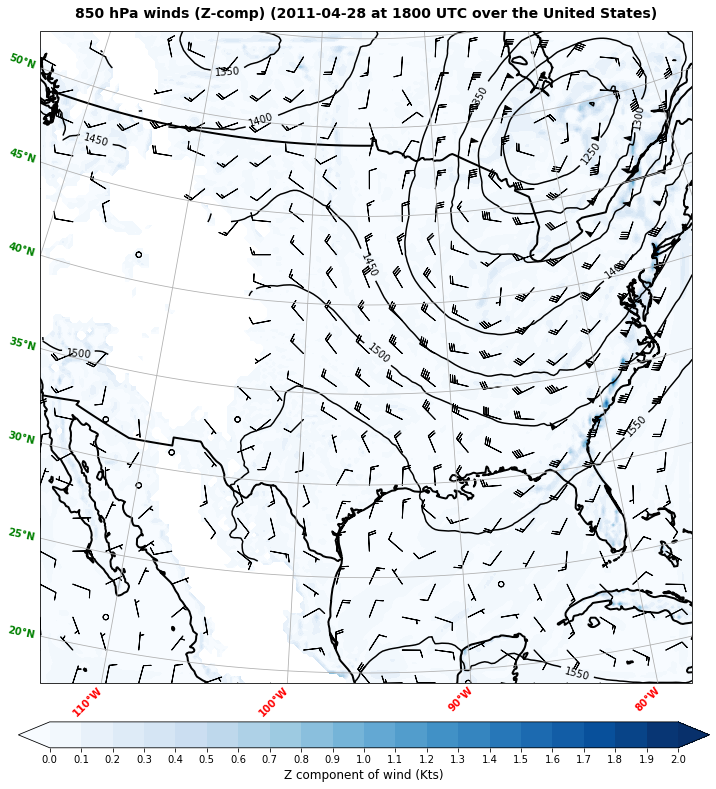

In [10]:
wrf_zwind_plot(wrfnc, 850, np.arange(0,2.1,0.1))

## For 500 hPa

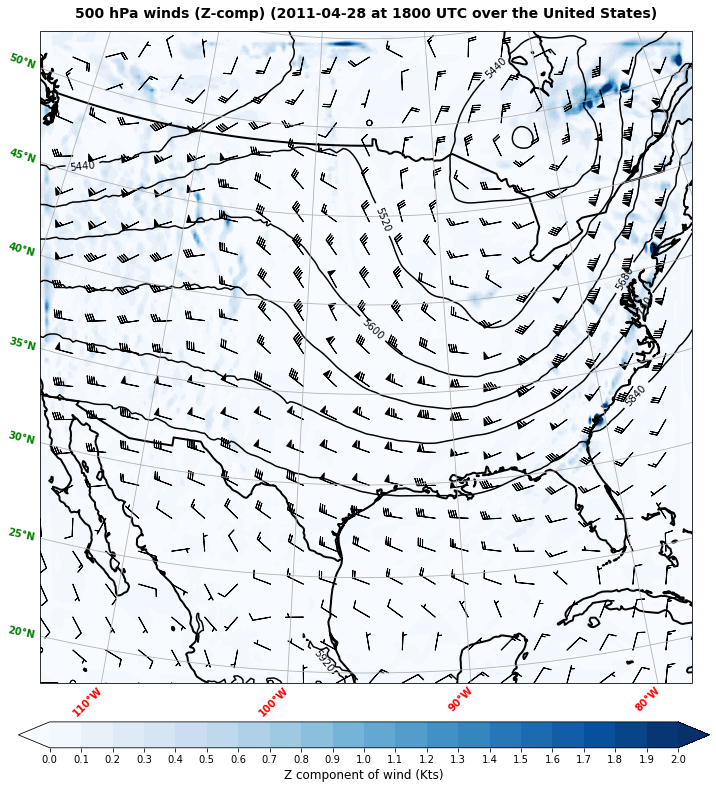

In [11]:
wrf_zwind_plot(wrfnc, 500, np.arange(0,2.1,0.1))

## For 250 hPa

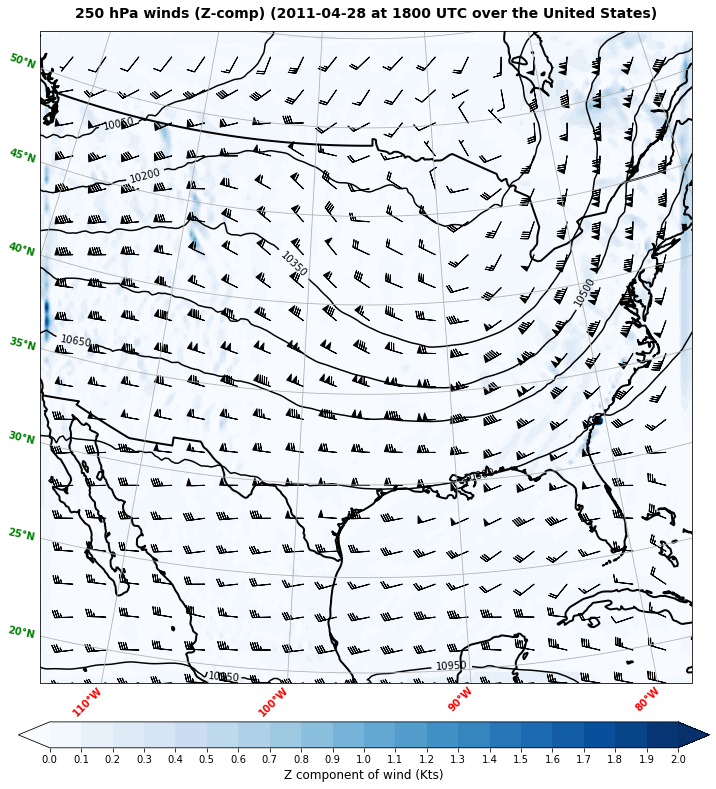

In [12]:
wrf_zwind_plot(wrfnc, 250, np.arange(0,2.1,0.1))

# Question 5

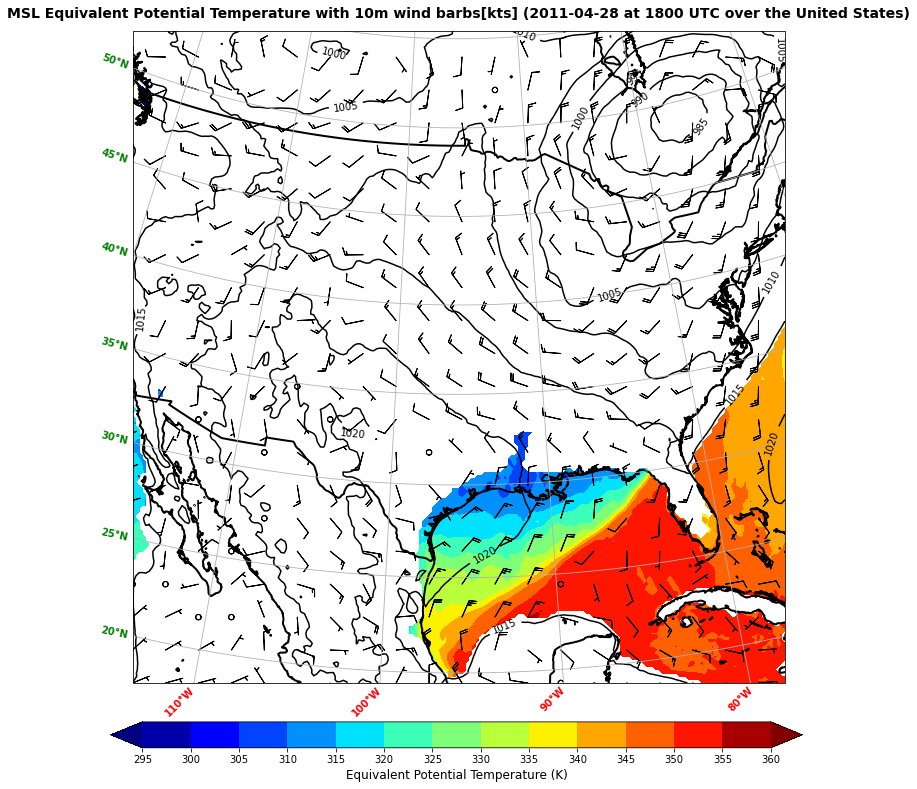

In [13]:
# Extract the pressure, sea level pressure, equivalent potential temperature and 10-m wind variables
p = getvar(wrfnc, "pressure")
slp = getvar(wrfnc, "slp")
theta_e = getvar(wrfnc,'theta_e', units='K')
U_10 = getvar(wrfnc, "uvmet10", units='kt')[0,:]
V_10 = getvar(wrfnc, "uvmet10", units='kt')[1,:]

# Interpolate the equivalent potential temperature to the mean sea level pressure
theta_e_at_slp = interplevel(theta_e, p, slp.mean())

# Get the lat/lon coordinates
lats, lons = latlon_coords(slp)

# Get the map projection information
cart_proj = get_cartopy(slp)

# Create the figure
fig = plt.figure(figsize=(12,12))
fig.patch.set_facecolor('xkcd:white') #Set the background = ‘white'
ax = plt.axes(projection=cart_proj)
ax.coastlines('10m', linewidth=2); ax.add_feature(cf.BORDERS, linewidth=2)

# Add the sea level pressure contours
slp_levels = np.arange(980,1030,5)
mslp_contours = plt.contour(to_np(lons), to_np(lats), to_np(slp), levels = slp_levels,
                       colors="black", linewidths=1.5, transform=crs.PlateCarree())
ax.clabel(mslp_contours)

# Add the MSL equivalent potential temperature contours
theta_levels = np.arange(295, 365,5)
theta_e_contours = plt.contourf(to_np(lons), to_np(lats), to_np(theta_e_at_slp), levels=theta_levels,
                             cmap=get_cmap('jet'), transform=crs.PlateCarree(), extend='both')

# Add the wind barbs, only plotting every 10th data point.
ax.barbs(to_np(lons[::10,::10]), to_np(lats[::10,::10]), to_np(U_10[::10, ::10]), 
          to_np(V_10[::10, ::10]), transform=crs.PlateCarree(), length=6)

# Set the map formatters and axes

gl = ax.gridlines(x_inline=False); gl.bottom_labels=True; gl.left_labels=True
gl.xformatter = LONGITUDE_FORMATTER; gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'color': 'red', 'weight': 'bold', 'rotation': 45}; gl.ylabel_style = {'color': 'green', 'weight': 'bold'}

cax = fig.add_axes([0.11,0.05,0.8,0.03])
cbar = plt.colorbar(theta_e_contours, cax=cax, orientation="horizontal", ticks=theta_levels)
cbar.set_label('Equivalent Potential Temperature (K)', fontsize=12)
ax.set_title(f'MSL Equivalent Potential Temperature with 10m wind barbs[kts] (2011-04-28 at 1800 UTC over the United States)', fontsize = 14, fontweight='bold', pad=13)
plt.savefig('./%s.png' %(f'labs4dynamics/lab6/msl_2011-04-28_theta_e'),bbox_inches='tight', dpi=100)